In [1]:
pip install  numpy scipy pandas sscikit-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sscikit-learn (from versions: none)
ERROR: No matching distribution found for sscikit-learn


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer
import numpy as np
import requests
import json
import os
import re
import ast
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder


In [3]:
def extract_english(value):
    """Extract English text from multilingual dicts, or return value as-is."""
    if isinstance(value, dict):
        return value.get("en", None)
    return value


def _normalize_record_en(record):
    """Normalize one record to English-only fields."""
    return {k: extract_english(v) for k, v in record.items()}


def fetch_paginated_api(base_url, output_dir="api_data", final_csv="full_places.csv", final_parquet="full_places.parquet"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_data = []
    url = base_url
    page_num = 1

    while url:
        print(f"Fetching page {page_num} from {url}")
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"API error: {response.status_code} - {response.text}")

        data = response.json()

        # --- Handle both list and dict in "data" ---
        raw_items = data.get("data", [])
        if isinstance(raw_items, dict):  
            # try extracting its values if it's wrapped
            raw_items = raw_items.get("items") or list(raw_items.values())
        if not isinstance(raw_items, list):
            raise Exception(f"Unexpected 'data' format: {type(raw_items)}")

        # Normalize to English
        items = [_normalize_record_en(it) for it in raw_items if isinstance(it, dict)]
        all_data.extend(items)

        # Save page to CSV for debugging
        page_df = pd.DataFrame(items)
        page_df.to_csv(f"{output_dir}/page_{page_num}.csv", index=False, encoding="utf-8")

        # Pagination
        url = data.get("next_page_url")
        page_num += 1

    # Combine everything
    full_df = pd.concat(
        [pd.read_csv(f"{output_dir}/{f}") for f in os.listdir(output_dir) if f.endswith(".csv")],
        ignore_index=True
    )

    # Save to CSV
    full_df.to_csv(final_csv, index=False, encoding="utf-8")

    # Save to Parquet
    full_df.to_parquet(final_parquet, index=False, engine="pyarrow")

    print(f"✅ Fetched {len(full_df)} items across {page_num-1} pages")
    print(f"💾 Saved to {final_csv} and {final_parquet}")

    return full_df


# Example usage
base_url = "https://trekio.net/api/get-places-data"
df = fetch_paginated_api(base_url)


Fetching page 1 from https://trekio.net/api/get-places-data
Fetching page 2 from https://trekio.net/api/get-places-data?page=2
Fetching page 3 from https://trekio.net/api/get-places-data?page=3
Fetching page 4 from https://trekio.net/api/get-places-data?page=4
Fetching page 5 from https://trekio.net/api/get-places-data?page=5
Fetching page 6 from https://trekio.net/api/get-places-data?page=6
Fetching page 7 from https://trekio.net/api/get-places-data?page=7
Fetching page 8 from https://trekio.net/api/get-places-data?page=8
Fetching page 9 from https://trekio.net/api/get-places-data?page=9
Fetching page 10 from https://trekio.net/api/get-places-data?page=10
Fetching page 11 from https://trekio.net/api/get-places-data?page=11
Fetching page 12 from https://trekio.net/api/get-places-data?page=12
Fetching page 13 from https://trekio.net/api/get-places-data?page=13
Fetching page 14 from https://trekio.net/api/get-places-data?page=14
Fetching page 15 from https://trekio.net/api/get-places-dat

In [ ]:
import os
import requests
import pandas as pd

def fetch_users_api(url="http://trekio.net/api/admin/users",
                    final_csv="users.csv",
                    final_parquet="users.parquet"):
    print(f"Fetching users from {url}")
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code} - {response.text}")

    data = response.json()

    # Handle response format
    raw_items = data.get("data", data)
    if not isinstance(raw_items, list):
        raise Exception(f"Unexpected 'data' format: {type(raw_items)}")

    df = pd.DataFrame(raw_items)

    # 🔑 Convert nested dicts/lists into JSON strings
    for col in df.columns:
        df[col] = df[col].apply(
            lambda x: x if isinstance(x, (str, int, float, bool, type(None))) else str(x)
        )

    # Save CSV
    df.to_csv(final_csv, index=False, encoding="utf-8")

    # Save Parquet
    df.to_parquet(final_parquet, index=False, engine="pyarrow")

    print(f"✅ Fetched {len(df)} users")
    print(f"💾 Saved to {final_csv} and {final_parquet}")

    return df


# Example usage
df = fetch_users_api()


Fetching users from http://trekio.net/api/admin/users
✅ Fetched 15 users
💾 Saved to users.csv and users.parquet


In [6]:
import pandas as pd

def merge_to_parquet(users_csv="users.csv",
                     places_csv="full_places.csv",
                     output_parquet="combined.parquet"):

    # Load both datasets
    users_df = pd.read_csv(users_csv)
    places_df = pd.read_csv(places_csv)

    # Add source column to distinguish
    users_df["source"] = "users"
    places_df["source"] = "places"

    # Align columns: union of both datasets
    all_cols = list(set(users_df.columns).union(set(places_df.columns)))
    users_df = users_df.reindex(columns=all_cols)
    places_df = places_df.reindex(columns=all_cols)

    # Concatenate
    combined_df = pd.concat([users_df, places_df], ignore_index=True)

    # Save to single Parquet
    combined_df.to_parquet(output_parquet, index=False, engine="pyarrow")

    print(f"✅ Combined {len(users_df)} users and {len(places_df)} places")
    print(f"💾 Saved to {output_parquet}")

    return combined_df


# Example usage
df = merge_to_parquet()


✅ Combined 15 users and 5257 places
💾 Saved to combined.parquet


In [7]:
print(df.columns.tolist())



['tour_guide', 'source', 'description', 'is_chat_allowed', 'created_at', 'city_name', 'travel_agency', 'phone', 'country_name', 'auto_approve_images', 'status', 'longitude', 'email', 'name', 'phone_country_code', 'device_token', 'latitude', 'lang', 'userID_fromFB', 'city_id', 'location', 'tour_recommendation', 'otp', 'type', 'id', 'short_description', 'passport_country', 'country', 'profile_picture']


In [ ]:
def extract_english(value):
    """Extract English text from multilingual dicts, or return value as-is."""
    if isinstance(value, dict):
        return value.get("en", None)
    return value


def _normalize_record_en(record):
    """Normalize one record to English-only fields."""
    return {k: extract_english(v) for k, v in record.items()}


def fetch_paginated_api(base_url, output_dir="api_data", final_csv="full_places.csv", final_parquet="full_places.parquet"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_data = []
    url = base_url
    page_num = 1

    while url:
        print(f"Fetching page {page_num} from {url}")
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"API error: {response.status_code} - {response.text}")

        data = response.json()

        # --- Handle both list and dict in "data" ---
        raw_items = data.get("data", [])
        if isinstance(raw_items, dict):  
            # try extracting its values if it's wrapped
            raw_items = raw_items.get("items") or list(raw_items.values())
        if not isinstance(raw_items, list):
            raise Exception(f"Unexpected 'data' format: {type(raw_items)}")

        # Normalize to English
        items = [_normalize_record_en(it) for it in raw_items if isinstance(it, dict)]
        all_data.extend(items)

        # Save page to CSV for debugging
        page_df = pd.DataFrame(items)
        page_df.to_csv(f"{output_dir}/page_{page_num}.csv", index=False, encoding="utf-8")

        # Pagination
        url = data.get("next_page_url")
        page_num += 1

    # Combine everything
    full_df = pd.concat(
        [pd.read_csv(f"{output_dir}/{f}") for f in os.listdir(output_dir) if f.endswith(".csv")],
        ignore_index=True
    )

    # Save to CSV
    full_df.to_csv(final_csv, index=False, encoding="utf-8")

    # Save to Parquet
    full_df.to_parquet(final_parquet, index=False, engine="pyarrow")

    print(f"✅ Fetched {len(full_df)} items across {page_num-1} pages")
    print(f"💾 Saved to {final_csv} and {final_parquet}")

    return full_df


# Example usage
base_url = "https://trekio.net/api/get-places-data"
df = fetch_paginated_api(base_url)


In [ ]:
print(df.columns)

Index(['id', 'city_id', 'city_name', 'country_name', 'name', 'description',
       'short_description', 'latitude', 'longitude', 'location', 'type',
       'created_at'],
      dtype='object')


In [ ]:
#read the pre saved full_places.parquet file and throw an exception if it's not found 
try:
    df = pd.read_parquet('full_places.parquet')
except FileNotFoundError:
    print("Error: 'full_places.parquet' not found. Ensure fetch step completed.")
    exit()
#some  exporation for the data form , nulls and columns
print(f"Initial DataFrame shape: {df.shape}")
df[['name', 'short_description', 'description', 'location', 'city_id']].head(3)
print(f"Unique locations: {df['location'].nunique()}")
print(f"Unique countries: {df['country_name'].nunique()}")
print(f"Unique types: {df['type'].nunique()}")
print(f"Unique cities: {df['city_name'].nunique()}")
print(f"Missing name values: {df['name'].isna().sum()}")
print(f"Missing description values: {df['description'].isna().sum()}")
print(f"Missing country_name values: {df['country_name'].isna().sum()}")
print(f"Missing city_name values: {df['city_name'].isna().sum()}")

print(f"Missing type values: {df['type'].isna().sum()}")


Initial DataFrame shape: (5257, 12)
Unique locations: 5174
Unique countries: 17
Unique types: 4
Unique cities: 116
Missing name values: 0
Missing description values: 0
Missing country_name values: 0
Missing city_name values: 0
Missing type values: 0


In [ ]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5257 entries, 0 to 5256
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5257 non-null   int64  
 1   city_id            5257 non-null   int64  
 2   city_name          5257 non-null   object 
 3   country_name       5257 non-null   object 
 4   name               5257 non-null   object 
 5   description        5257 non-null   object 
 6   short_description  5257 non-null   object 
 7   latitude           5229 non-null   float64
 8   longitude          5229 non-null   float64
 9   location           5257 non-null   object 
 10  type               5257 non-null   object 
 11  created_at         5257 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 493.0+ KB
None
                id      city_id     latitude    longitude
count  5257.000000  5257.000000  5229.000000  5229.000000
mean    773.117748    70.419251    3

In [ ]:
df.head()

,id,city_id,city_name,country_name,name,description,short_description,latitude,longitude,location,type,created_at
0,1570,151,Hội An,Vietnam,Cam Kim Island,{'Location': ['Discover Cam Kim Island in Hoi ...,"Explore the tranquil Cam Kim Island, a hidden ...",15.862381,108.323470,https://www.google.com/maps?q=Cam%20Kim%20Isla...,tourist place,2025-08-20T23:30:10.000000Z
1,1569,151,Hội An,Vietnam,Đình Cẩm Phô,{'Location': ['Discover Đình Cẩm Phô in Hội An...,Tranquil temple & community center. Serene tem...,15.878240,108.324058,https://www.google.com/maps?q=%C4%90%C3%ACnh%2...,tourist place,2025-08-20T23:29:08.000000Z
2,1568,151,Hội An,Vietnam,Hoi An ancient town,"{'Location': ['Discover the magic of Hoi An, V...","Immerse in the charm of Hoi An ancient town, a...",15.876156,108.326400,https://www.google.com/maps?q=Hoi%20An%20ancie...,tourist place,2025-08-20T23:28:19.000000Z
3,1567,151,Hội An,Vietnam,An Bang Beach,{'Location': ['Discover the tranquil beauty of...,White-sand beach with trees & palapas. Tranqui...,15.913607,108.340649,https://www.google.com/maps?q=An%20Bang%20Beac...,tourist place,2025-08-20T23:25:39.000000Z
4,691,151,Hội An,Vietnam,Lantern Thuy Tam,{'Location': ['Explore the bustling shopping s...,Discover a vibrant shopping haven at Lantern T...,15.877257,108.329460,https://www.google.com/maps?q=Lantern%20Thuy%2...,shop,2025-08-20T23:16:16.000000Z


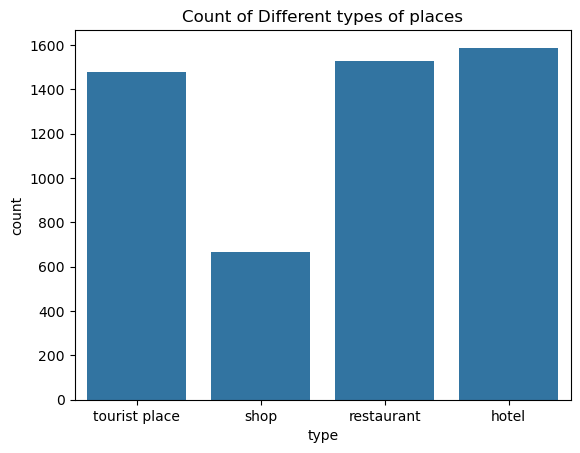

In [ ]:
sns.countplot(x='type', data = df)
plt.title('Count of Different types of places')
plt.show()

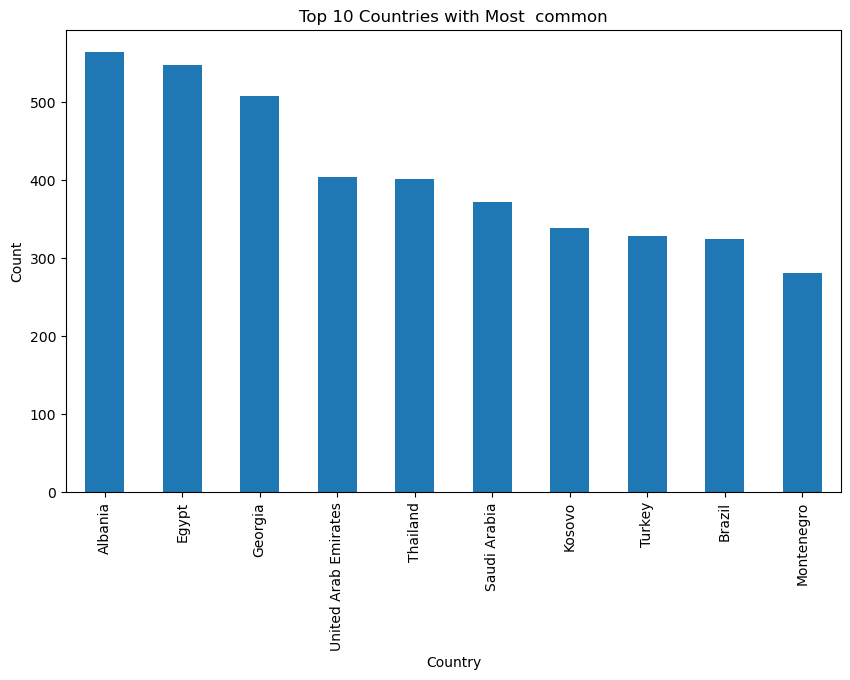

In [ ]:
plt.figure(figsize=(10, 6))
df['country_name'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries with Most  common')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

In [ ]:
# # TF-IDF Vectorization
# # convert the combined text column into numerical vectors using Term Frequency-Inverse Document Frequency (TF-IDF)
# # 'stop_words' removes common words.
# tfidf = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf.fit_transform(df['description'])

In [ ]:
df.head()

,id,city_id,city_name,country_name,name,description,short_description,latitude,longitude,location,type,created_at
0,1570,151,Hội An,Vietnam,Cam Kim Island,{'Location': ['Discover Cam Kim Island in Hoi ...,"Explore the tranquil Cam Kim Island, a hidden ...",15.862381,108.323470,https://www.google.com/maps?q=Cam%20Kim%20Isla...,tourist place,2025-08-20T23:30:10.000000Z
1,1569,151,Hội An,Vietnam,Đình Cẩm Phô,{'Location': ['Discover Đình Cẩm Phô in Hội An...,Tranquil temple & community center. Serene tem...,15.878240,108.324058,https://www.google.com/maps?q=%C4%90%C3%ACnh%2...,tourist place,2025-08-20T23:29:08.000000Z
2,1568,151,Hội An,Vietnam,Hoi An ancient town,"{'Location': ['Discover the magic of Hoi An, V...","Immerse in the charm of Hoi An ancient town, a...",15.876156,108.326400,https://www.google.com/maps?q=Hoi%20An%20ancie...,tourist place,2025-08-20T23:28:19.000000Z
3,1567,151,Hội An,Vietnam,An Bang Beach,{'Location': ['Discover the tranquil beauty of...,White-sand beach with trees & palapas. Tranqui...,15.913607,108.340649,https://www.google.com/maps?q=An%20Bang%20Beac...,tourist place,2025-08-20T23:25:39.000000Z
4,691,151,Hội An,Vietnam,Lantern Thuy Tam,{'Location': ['Explore the bustling shopping s...,Discover a vibrant shopping haven at Lantern T...,15.877257,108.329460,https://www.google.com/maps?q=Lantern%20Thuy%2...,shop,2025-08-20T23:16:16.000000Z


In [ ]:
# , 'short_description','name','country_name','city_name'

Shape of dataset: (5257, 12)

Columns:
 ['id', 'city_id', 'city_name', 'country_name', 'name', 'description', 'short_description', 'latitude', 'longitude', 'location', 'type', 'created_at']

Missing values:
 id                    0
city_id               0
city_name             0
country_name          0
name                  0
description           0
short_description     0
latitude             28
longitude            28
location              0
type                  0
created_at            0
dtype: int64

Data types:
 id                     int64
city_id                int64
city_name             object
country_name          object
name                  object
description           object
short_description     object
latitude             float64
longitude            float64
location              object
type                  object
created_at            object
dtype: object

Summary statistics:
                  id      city_id city_name country_name         name  \
count   5257.000000  

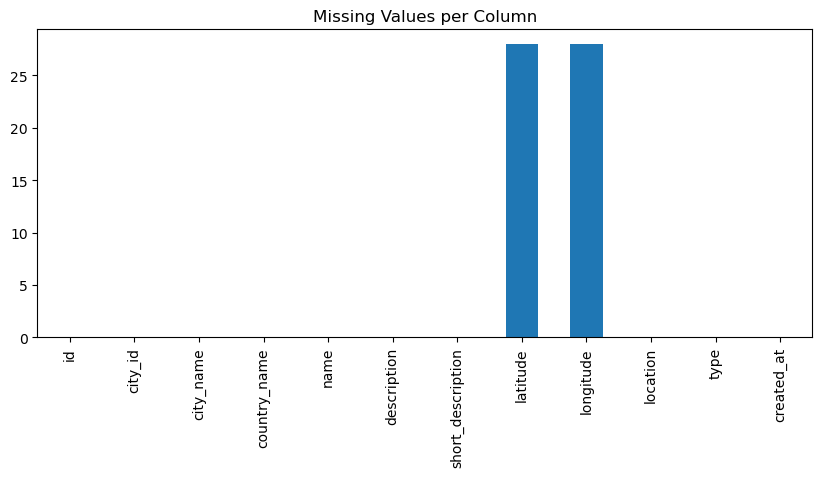


Sample rows:
 <bound method NDFrame.head of         id  city_id city_name country_name  \
0     1570      151    Hội An      Vietnam   
1     1569      151    Hội An      Vietnam   
2     1568      151    Hội An      Vietnam   
3     1567      151    Hội An      Vietnam   
4      691      151    Hội An      Vietnam   
...    ...      ...       ...          ...   
5252    69       35  Hurghada        Egypt   
5253    68       35  Hurghada        Egypt   
5254    67       35  Hurghada        Egypt   
5255    98       35  Hurghada        Egypt   
5256    97       35  Hurghada        Egypt   

                                       name  \
0                            Cam Kim Island   
1                              Đình Cẩm Phô   
2                       Hoi An ancient town   
3                             An Bang Beach   
4                          Lantern Thuy Tam   
...                                     ...   
5252                     Caves Beach Resort   
5253  Sunrise Holidays Res

In [ ]:
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe(include="all"))

df.isnull().sum().plot(kind="bar", figsize=(10,4), title="Missing Values per Column")
plt.show()

print("\nSample rows:\n", df.head)

In [ ]:
duplicate_rows = df[df.duplicated()]
print(f"Duplicate rows: {duplicate_rows.shape[0]}")



Duplicate rows: 0


In [ ]:
text_columns = ["short_description", "description", "location"]

for col in text_columns:
    df[col] = df[col].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["city_id"] = le.fit_transform(df["city_id"].astype(str))


In [ ]:
df = df.drop(columns=["latitude", "longitude","created_at"])

df.head()

,id,city_id,city_name,country_name,name,description,short_description,location,type
0,1570,56,Hội An,Vietnam,Cam Kim Island,location discover cam kim island in hoi an vie...,explore the tranquil cam kim island a hidden g...,httpswwwgooglecommapsqcam20kim20islandftid0x31...,tourist place
1,1569,56,Hội An,Vietnam,Đình Cẩm Phô,location discover nh cm ph in hi an vietnam a...,tranquil temple community center serene templ...,httpswwwgooglecommapsqc490c3acnh20ce1baa9m20ph...,tourist place
2,1568,56,Hội An,Vietnam,Hoi An ancient town,location discover the magic of hoi an vietnam ...,immerse in the charm of hoi an ancient town a ...,httpswwwgooglecommapsqhoi20an20ancient20townft...,tourist place
3,1567,56,Hội An,Vietnam,An Bang Beach,location discover the tranquil beauty of an ba...,whitesand beach with trees palapas tranquil t...,httpswwwgooglecommapsqan20bang20beachftid0x314...,tourist place
4,691,56,Hội An,Vietnam,Lantern Thuy Tam,location explore the bustling shopping scene i...,discover a vibrant shopping haven at lantern t...,httpswwwgooglecommapsqlantern20thuy20tamftid0x...,shop


In [ ]:
df["country_name"] = df["country_name"].astype("category")
df["city_name"] = df["city_name"].astype("category")
df["type"] = df["type"].astype("category")


In [ ]:
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe(include="all"))


Data types:
 id                      int64
city_id                 int64
city_name            category
country_name         category
name                   object
description            object
short_description      object
location               object
type                 category
dtype: object

Summary statistics:
                  id      city_id city_name country_name         name  \
count   5257.000000  5257.000000      5257         5257         5257   
unique          NaN          NaN       116           17         5110   
top             NaN          NaN     Dubai      Albania  Clock Tower   
freq            NaN          NaN       223          564            4   
mean     773.117748    63.663116       NaN          NaN          NaN   
std      466.363575    30.301630       NaN          NaN          NaN   
min        3.000000     0.000000       NaN          NaN          NaN   
25%      373.000000    41.000000       NaN          NaN          NaN   
50%      720.000000    68.000000

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


   ---------------------------------------- 0.0/13.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.9 MB 3.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.3/13.9 MB 3.9 MB/s eta 0:00:04
   ------ --------------------------------- 2.1/13.9 MB 3.9 MB/s eta 0:00:04
   -------- ------------------------------- 2.9/13.9 MB 3.9 MB/s eta 0:00:03
   ---------- ----------------------------- 3.7/13.9 MB 3.9 MB/s eta 0:00:03
   ------------ --------------------------- 4.5/13.9 MB 3.9 MB/s eta 0:00:03
   --------------- ------------------------ 5.2/13.9 MB 3.9 MB/s eta 0:00:03
   ------------------ --------------------- 6.3/13.9 MB 3.9 MB/s eta 0:00:02
   -------------------- ------------------- 7.1/13.9 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 7.9/13.9 MB 3.9 MB/s eta 0:00:02
   ------------------------ --------------- 8.7/13.9 MB 3.9 MB/s eta 0:00:02
   --------------------------- ------------ 9.4/13.9 MB 3.9 MB/s eta 0:00:02
   ---

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab") 
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# --- Text cleaning function ---
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove special characters, numbers, punctuation
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization using spaCy
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]

    return " ".join(lemmas)

text_columns = ["name", "description", "short_description"]
for col in text_columns:
    df[f"{col}_clean"] = df[col].apply(preprocess_text)

print(df[[col for col in df.columns if "_clean" in col]].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


         name_clean                                  description_clean  \
0    cam kim island  location discover cam kim island hoi vietnam p...   
1          nh cm ph  location discover nh cm ph hi vietnam historic...   
2  hoi ancient town  location discover magic hoi vietnam historic g...   
3        bang beach  location discover tranquil beauty bang beach h...   
4  lantern thuy tam  location explore bustling shopping scene hoi v...   

                             short_description_clean  
0  explore tranquil cam kim island hidden gem hoi...  
1  tranquil temple community center serene temple...  
2  immerse charm hoi ancient town unesco world he...  
3  whitesand beach tree palapas tranquil treeline...  
4  discover vibrant shopping lantern thuy tam off...  


In [ ]:
df.head()

,id,city_id,city_name,country_name,name,description,short_description,location,type,name_clean,description_clean,short_description_clean
0,1570,56,Hội An,Vietnam,Cam Kim Island,location discover cam kim island in hoi an vie...,explore the tranquil cam kim island a hidden g...,httpswwwgooglecommapsqcam20kim20islandftid0x31...,tourist place,cam kim island,location discover cam kim island hoi vietnam p...,explore tranquil cam kim island hidden gem hoi...
1,1569,56,Hội An,Vietnam,Đình Cẩm Phô,location discover nh cm ph in hi an vietnam a...,tranquil temple community center serene templ...,httpswwwgooglecommapsqc490c3acnh20ce1baa9m20ph...,tourist place,nh cm ph,location discover nh cm ph hi vietnam historic...,tranquil temple community center serene temple...
2,1568,56,Hội An,Vietnam,Hoi An ancient town,location discover the magic of hoi an vietnam ...,immerse in the charm of hoi an ancient town a ...,httpswwwgooglecommapsqhoi20an20ancient20townft...,tourist place,hoi ancient town,location discover magic hoi vietnam historic g...,immerse charm hoi ancient town unesco world he...
3,1567,56,Hội An,Vietnam,An Bang Beach,location discover the tranquil beauty of an ba...,whitesand beach with trees palapas tranquil t...,httpswwwgooglecommapsqan20bang20beachftid0x314...,tourist place,bang beach,location discover tranquil beauty bang beach h...,whitesand beach tree palapas tranquil treeline...
4,691,56,Hội An,Vietnam,Lantern Thuy Tam,location explore the bustling shopping scene i...,discover a vibrant shopping haven at lantern t...,httpswwwgooglecommapsqlantern20thuy20tamftid0x...,shop,lantern thuy tam,location explore bustling shopping scene hoi v...,discover vibrant shopping lantern thuy tam off...


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load SBERT model (English only)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Choose text representation: combine name + description + short_description
def combine_text(row):
    return f"{row['name_clean']} {row['description_clean']} {row['short_description_clean']}"

df["text_for_embedding"] = df.apply(combine_text, axis=1)

# Generate embeddings
embeddings = model.encode(df["text_for_embedding"].tolist(), show_progress_bar=True)

# Store embeddings in DataFrame (optional: as separate columns or np.array)
df["embeddings"] = list(embeddings)

# Inspect shape
print("Embeddings shape:", embeddings.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\anaconda\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/165 [00:00<?, ?it/s]

Embeddings shape: (5257, 384)
